# A/B/A тестирование продаж маркетплейса

# Задание:
К вам попали результаты A/A/B-тестирования от одного известного маркетплейса.

- sample_a, sample_c — АА-группы,
- sample_b — отдельная группа.

В каждом датасете есть три типа действий пользователей: 0 — клик, 1 — просмотр и 2 — покупка (пользователь просматривает выдачу товаров, кликает на понравившийся товар и совершает покупку).

Маркетплейс ориентируется на следующие метрики:

- ctr (отношение кликов к просмотрам товаров);
- purchase rate (отношение покупок к просмотрам товаров);
- gmv (оборот, сумма произведений количества покупок на стоимость покупки, где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя)).

Данные уже почищены по сессиям, вы можете использовать их в агрегированном виде. Ваша задача — понять, нет ли проблемы с разъезжанием сплитов и улучшает ли алгоритм B работу маркетплейса.

> В данном ноутбуке во избежание путаницы 2-я А группа именуется C группой

# Библиотеки и данные

In [279]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import numpy as np

#импортируем библиотеку для z-теста
from statsmodels.stats.proportion import proportions_ztest

#В колабе импортируем все необходимые библиотеки
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Привязываем гуглдиск к колабу
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Загружаем файл в колаб
download = drive.CreateFile({"id": "1EdzNqq-52evjkkvu10_-OFyElCIDTpNO"})
# https://drive.google.com/file/d/1EdzNqq-52evjkkvu10_-OFyElCIDTpNO/view?usp=sharing
download.GetContentFile("item_prices.zip")

download = drive.CreateFile({"id": "1A8kXwEAJG2c6K_T48WDJmgpToECwSKL7"})
# https://drive.google.com/file/d/1A8kXwEAJG2c6K_T48WDJmgpToECwSKL7/view?usp=sharing
download.GetContentFile("sample_a.zip")

download = drive.CreateFile({"id": "1VnzwUqfgBBUaoPQAX9jLfO-UeSwRNqaQ"})
# https://drive.google.com/file/d/1VnzwUqfgBBUaoPQAX9jLfO-UeSwRNqaQ/view?usp=sharing
download.GetContentFile("sample_b.zip")

download = drive.CreateFile({"id": "1yu4UerR0PpaaKg8oHhT6fuzQUsfMbcG3"})
# https://drive.google.com/file/d/1yu4UerR0PpaaKg8oHhT6fuzQUsfMbcG3/view?usp=drive_link
download.GetContentFile("sample_c.zip")

item_prices = pd.read_csv("item_prices.zip")
sample_a = pd.read_csv("sample_a.zip")
sample_b = pd.read_csv("sample_b.zip")
sample_c = pd.read_csv("sample_c.zip")

In [280]:
item_prices.head()

,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


In [281]:
item_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   item_id     1000 non-null   int64
 1   item_price  1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB


In [282]:
sample_a.head()

,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


In [283]:
sample_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188912 entries, 0 to 1188911
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1188912 non-null  int64
 1   item_id    1188912 non-null  int64
 2   action_id  1188912 non-null  int64
dtypes: int64(3)
memory usage: 27.2 MB


In [284]:
sample_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198438 entries, 0 to 1198437
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1198438 non-null  int64
 1   item_id    1198438 non-null  int64
 2   action_id  1198438 non-null  int64
dtypes: int64(3)
memory usage: 27.4 MB


In [285]:
sample_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205510 entries, 0 to 1205509
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1205510 non-null  int64
 1   item_id    1205510 non-null  int64
 2   action_id  1205510 non-null  int64
dtypes: int64(3)
memory usage: 27.6 MB


Выборки сопоставимы по количеству наблюдений.   
Тем не менее выборка A меньше, чем выборки С и B.

## Очистка данных

Напомню, в каждом датасете есть три типа действий пользователей:
- 1 — просмотр, пользователь просматривает выдачу товаров
- 0 — клик, кликает на понравившийся товар
- 2 — покупка.   

Проверим наличие ситуаций, когда происходит покупка/клик без действия просмотра.  

Для этого сгруппируем данные по пользователю и товару и суммируем значения столбца actoin_id.  
Если товар приобретен без просмотра, что является ошибкой, то сумма всех действий в паре пользователь-товар будет равна 2.
Если произведен клик без просмотра, что тоже является ошибкой, то сумма всех действий в паре пользователь-товар будет равна 0.

Также в данном блоке удалим дубликаты, если они есть.


In [286]:
# функция перевода имени переменной в строку
def var2str(var, vars_data = locals()):
    return [var_name for var_name in vars_data if id(var) == id(vars_data[var_name])]

def test_group(data):
  name = var2str(data)[0]
  test = data.groupby(['user_id','item_id'])['action_id'].agg('sum')
  print(f'Количество покупок без просмотра в {name}: {len(test. loc [ lambda x : x == 2])}')
  print(f'Количество кликов без просмотра в {name}: {len(test. loc [ lambda x : x == 0])}')
  print(f'Количество дубликатов в {name}: {len(data)- len(data.drop_duplicates ())}')
  print('')

In [287]:
test_group(sample_a)
test_group(sample_b)
test_group(sample_c)

Количество покупок без просмотра в sample_a: 0
Количество кликов без просмотра в sample_a: 0
Количество дубликатов в sample_a: 0

Количество покупок без просмотра в sample_b: 0
Количество кликов без просмотра в sample_b: 0
Количество дубликатов в sample_b: 0

Количество покупок без просмотра в sample_c: 0
Количество кликов без просмотра в sample_c: 0
Количество дубликатов в sample_c: 0



## **Оценим и исключим пересечения данных в группах**

Проверим, есть ли пользователи и сколько, которые в процессе A/B/A-теста попали вo все тестовые группы?

In [288]:
#создаем множество пользователей группы А
set_a = set(sample_a['user_id'])
#cоздаём множество пользователей группы B
set_b = set(sample_b['user_id'])
#cоздаём множество пользователей группы C
set_c = set(sample_c['user_id'])
#Пересекаем два этих множества, создаем множество пересечений пользователей групп А и B
set_intersection = set_a.intersection(set_b,set_c)
#вычисляем количество элементов в полученном множестве
print(f'Количество уникальных пользователей в группе A: {len(set_a)}')
print(f'Количество уникальных пользователей в группе В: {len(set_b)}')
print(f'Количество уникальных пользователей в группе C: {len(set_c)}')
print(f'Количество пользователей, попавших в три группы: {len(set_intersection)}')


Количество уникальных пользователей в группе A: 996
Количество уникальных пользователей в группе В: 996
Количество уникальных пользователей в группе C: 994
Количество пользователей, попавших в три группы: 0


Выборки независимы. Данные чисты.

# Рассчитаем метрики

Маркетплейс ориентируется на следующие метрики:

- ctr (отношение кликов к просмотрам товаров);
- purchase rate (отношение покупок к просмотрам товаров);
- gmv (Gross Merchandise Volume) оборот, сумма произведений количества покупок на стоимость покупки, где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

In [289]:
def metrics_test(data):
  """ Функция для расчета метрик

    Args:
        data (DataFrame):выборка, для которой нужно рассчитать метрики

    Returns:
        ctr, purchase_rate, gmv: Рассчитанные метрики ctr, purchase_rate, gmv
  """
  name = var2str(data)[0]

  ctr = round((data[data['action_id'] == 0].shape[0]/data[data['action_id'] == 1].shape[0]),2)
  purchase_rate = round((data[data['action_id'] == 2].shape[0]/data[data['action_id'] == 1].shape[0]),2)
  merge_table = data.merge(item_prices, how = 'left', on ='item_id')
  gmv = merge_table[merge_table['action_id'] == 2].groupby(['user_id'])['item_price'].sum().sum()
  print(f'ctr в группе {name}: {ctr}')
  print(f'purchase_rate в группе {name}: {purchase_rate}')
  print(f'gmv в группе {name}: {gmv} \n')
  return ctr, purchase_rate, gmv

Произаедём расчет метрик для групп А,В,С

In [290]:
ctr_a, purchase_rate_a, gmv_a = metrics_test(sample_a)
ctr_b, purchase_rate_b, gmv_b = metrics_test(sample_b)
ctr_c, purchase_rate_c, gmv_c = metrics_test(sample_c)

ctr в группе sample_a: 0.2
purchase_rate в группе sample_a: 0.05
gmv в группе sample_a: 53060177 

ctr в группе sample_b: 0.16
purchase_rate в группе sample_b: 0.1
gmv в группе sample_b: 106047378 

ctr в группе sample_c: 0.21
purchase_rate в группе sample_c: 0.06
gmv в группе sample_c: 63614910 



In [317]:
print(f'Отношение gmv в группе В к группам А и С вместе взятым: {round(gmv_b/(gmv_a + gmv_c),2)}')

Отношение gmv в группе В к группам А и С вместе взятым: 0.91


Визуализируем результаты

[Text(0.5, 1.0, 'gmv')]

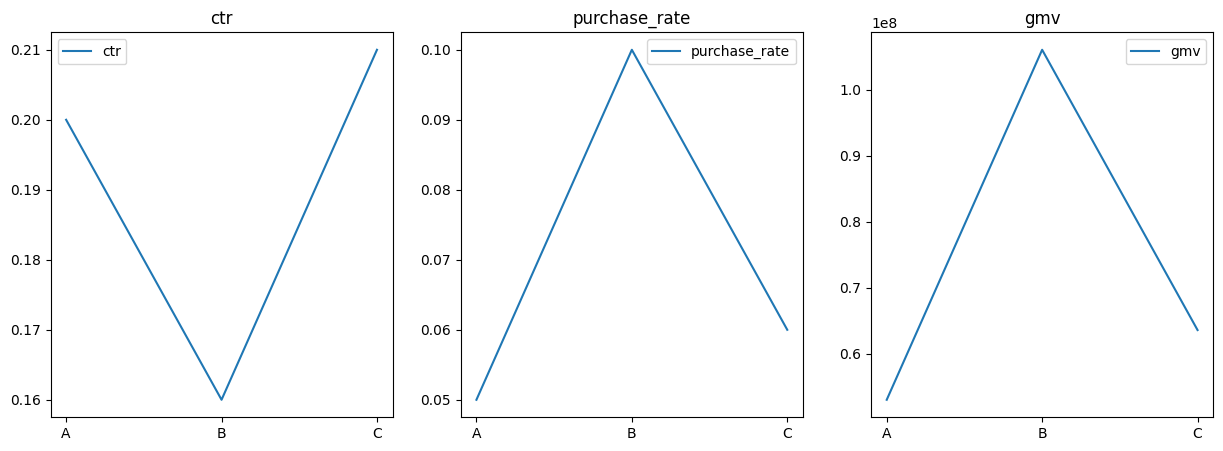

In [291]:
ctr = [ctr_a,ctr_b,ctr_c]
purchase_rate = [purchase_rate_a, purchase_rate_b, purchase_rate_c]
gmv = [gmv_a, gmv_b, gmv_c]

name = ['А','В','С']
ctr_plot = pd.DataFrame(ctr, name, columns = ['ctr'])
purchase_rate_plot = pd.DataFrame(purchase_rate, name, columns = ['purchase_rate'])
gmv_plot = pd.DataFrame(gmv, name, columns = ['gmv'])

f, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

sns.lineplot(ctr_plot, ax = axs[0]).set (title='ctr')
sns.lineplot(purchase_rate_plot, ax = axs[1]).set (title='purchase_rate')
sns.lineplot(gmv_plot, ax = axs[2]).set (title='gmv')

Отношение кликов к просмотрам(ctr) в варианте В ниже, чем у вариантов А и С.  

Отношение покупок к показам(purchase_rate) и общий оборот(gmv) выше у В, чем у А и С.  
   
Т.о. можно предположить, что реагируют на вариант объявления В хуже, но клиент откликается более качественный.   
Также можно предположить, что варианты А и С по остальным метрикам друг от друга значительно не отличаются.   

В дальнейшем мы проверим эти гипотезы.

# Проверка на нормальность распределения

А пока проверим данные на нормальность, это необходимо для выбора статистического теста.  
Отследим, сколько покупок совершили покупатели в каждой из групп.  
Эти данные могут описываться нормальным распределением.

In [292]:
def test_shapiro(data, alpha = 0.01):
  # проводим тест Шапиро — Уилка
  _, p = stats.shapiro(data)
  print('p-value = %.3f' % (p))
  # интерпретируем результат
  if p <= alpha:
      print('Распределение не нормальное')
  else:
      print('Распределение нормальное \n')

In [293]:
def shapiro_test(data):
  """ Функция для подготовки данных, расчета теста Шапиро — Уилка и визуализации распределения

    Args:
        data (DataFrame):выборка

    Returns:
        : Функция выводит на экран данные о нормальности распределения выборки и гистограмму распределения признака
  """
  name = var2str(data)[0]
  print(f'{name}')
  item_prices.rename(columns = {'item_price':'sum_sell'}, inplace = True )
  merge_table = data.merge(item_prices, how = 'left', on ='item_id')
  sum_sell = merge_table[merge_table['action_id'] == 2].groupby(['user_id'])['sum_sell'].sum()
  test_shapiro(sum_sell)
  sns.histplot(sum_sell)

Применим функцию определения распределения к выборкам

sample_a
p-value = 0.125
Распределение нормальное 

sample_b
p-value = 0.846
Распределение нормальное 

sample_c
p-value = 0.020
Распределение нормальное 



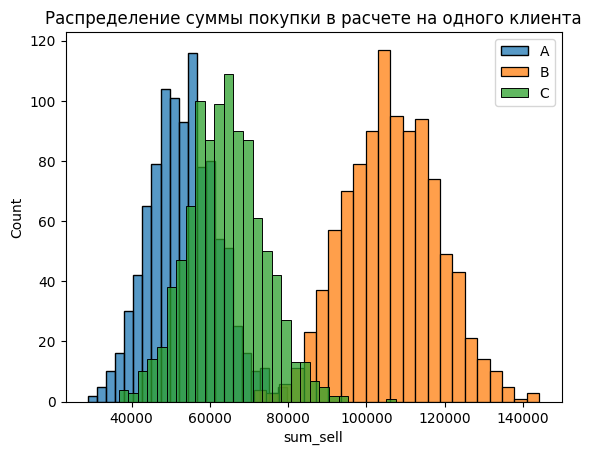

In [294]:
shapiro_test(sample_a)
shapiro_test(sample_b)
shapiro_test(sample_c)
plt.title('Распределение суммы покупки в расчете на одного клиента')
plt.legend(labels=['A', 'B', 'C']);

Распределения нормальные, будем применять параметрические тесты.

По графику распределения видно, что в группе В клиенты в среднем тратили больше денег, чем в группах А и С.  

Проверим данное утверждение с помощью теста на равенство средних.

# Тест на равенство средних

## Средняя сумма покупки

In [295]:
def data_mean(data):
  """ Функция для подготовки данных для анализа средних продаж

    Args:
        data (DataFrame):выборка

    Returns:
       sum_sell (DataFrame): Таблица с сгрупппированными по покупателям продажами
  """
  item_prices.rename(columns = {'item_price':'sum_sell'}, inplace = True )
  # объединение выборки и таблицы с ценой товаров
  merge_table = data.merge(item_prices, how = 'left', on ='item_id')
  # группировка по пользователям и агрегирование по сумме продаж
  sum_sell = merge_table[merge_table['action_id'] == 2].groupby(['user_id'])['sum_sell'].sum().to_numpy()
  return sum_sell

### Пара А и В



In [296]:
# нулевая и альтернативная гипотезы
H0 = 'Cредняя сумма покупки в группе А больше или равна средней суммы покупки в группе В'
H1 = 'Cредняя сумма покупки в группе А меньше средней суммы покупки в группе В'
alpha = 0.05 # уровень значимости

data_A = data_mean(sample_a)
data_B = data_mean(sample_b)

# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(data_A, data_B)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p_value = stats.ttest_ind(data_A, data_B, alternative='less', equal_var=False)

print('p-value = {:.3f}'.format(p))

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Тест на равенство дисперсий
p-value = 0.000
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.

Тест на равенство средних
p-value = 0.000
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Cредняя сумма покупки в группе А меньше средней суммы покупки в группе В


### Пара А и С

In [297]:
# нулевая и альтернативная гипотезы
H0 = 'Cредняя сумма покупки в группе А равна средней суммы покупки в группе C'
H1 = 'Cредняя сумма покупки в группе А не равна средней суммы покупки в группе C'

# задаём уровень значимости
alpha = 0.05

data_A = data_mean(sample_a)
data_C = data_mean(sample_c)

# проводим тест Левена на равенство дисперсий
print('Тест на равенство дисперсий')
result = stats.levene(data_A, data_C)
p = result[1]
print('p-value = {:.3f}'.format(p))

# интерпретируем результат
if p <= alpha:
    print('Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.')
else:
    print('Дисперсии одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=True.')

# проводим тест на сравнение средних в группах
print('\nТест на равенство средних')
_, p_value = stats.ttest_ind(data_A, data_C, equal_var=False)
print('p-value = {:.3f}'.format(p))

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

Тест на равенство дисперсий
p-value = 0.006
Дисперсии не одинаковы, в stats.ttest_ind нужно использовать параметр equal_var=False.

Тест на равенство средних
p-value = 0.006
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Cредняя сумма покупки в группе А не равна средней суммы покупки в группе C


Тест подтверждает, что продажи в группе В статистически выше, чем в А.  
Однако, средние суммы покупок в А и С не совпадают, что подвергает сомнению идею, что на продажи в В влияет именно алгоритм.

# Тесты на равенство долей

Теперь сравним статистическую значимость различий метрик по группам

## CTR
Для проверки гипотезы о равенстве долевых показателей в группах применим Z-тест для пропорций.
Т.к.выборка более 30 элементов, типы переменных количественные и сравниваются 2 группы.



In [298]:
def ctr_table(data1, data2):
  """ Функция для подготовки данных для расчета показателя ctr

    Args:
        data1, data2 (DataFrame):сравиниваемые выборки

    Returns:
       table_ztest (DataFrame): Таблица с сгрупппированными для расчета ctr данными
  """
  name1 = var2str(data1)[0]
  name2 = var2str(data2)[0]

  success1 = data1[data1['action_id'] == 0].shape[0]
  success2 = data2[data2['action_id'] == 0].shape[0]
  all1 = data1[data1['action_id'] == 1].shape[0]
  all2 = data2[data2['action_id'] == 1].shape[0]

  data = {name1: [success1, all1], name2: [success2, all2]}
  table_ztest = pd.DataFrame.from_dict(data, orient='index', columns=['success', 'count'])
  print('ctr_compare')
  print(table_ztest)
  return table_ztest

### Пара А и В

In [299]:
ctr_compare = ctr_table(sample_a, sample_b)

ctr_compare
          success   count
sample_a   190226  951130
sample_b   152183  951141


In [300]:
# нулевая и альтернативная гипотезы
H0 = 'Отношение кликов к просмотрам(ctr) в группах А и B равны'
H1 = 'Отношение кликов к просмотрам(ctr) в группе А выше, чем в группе B'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=ctr_compare['success'], #число "успехов"
    nobs=ctr_compare['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Отношение кликов к просмотрам(ctr) в группе А выше, чем в группе B


### Пара А и C

In [301]:
ctr_compare = ctr_table(sample_a, sample_c)

ctr_compare
          success   count
sample_a   190226  951130
sample_c   199336  949221


In [302]:
# нулевая и альтернативная гипотезы
H0 = 'Отношение кликов к просмотрам(ctr) в группах А и C равны'
H1 = 'Отношение кликов к просмотрам(ctr) в группе А выше, чем в группе C'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=ctr_compare['success'], #число "успехов"
    nobs=ctr_compare['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  1.0
Принимаем нулевую гипотезу. Отношение кликов к просмотрам(ctr) в группах А и C равны


По результатам сравнения метрик можно подтвердить предварительные выводы на основе визуализации, покупатели одинаково часто кликают на показы в группах А и С и чаще, чем в группе В.

## Purchase_rate
Для проверки гипотезы о равенстве долевых показателей в группах применим Z-тест для пропорций.
Т.к.выборка более 30 элементов, типы переменных количественные и сравниваются 2 группы.



In [303]:
def purchase_table(data1, data2):
  """ Функция для подготовки данных для расчета показателя purchase_rate

    Args:
        data1, data2 (DataFrame):сравиниваемые выборки

    Returns:
       table_ztest (DataFrame): Таблица с сгрупппированными для расчета ctr данными
  """
  name1 = var2str(data1)[0]
  name2 = var2str(data2)[0]

  success1 = data1[data1['action_id'] == 2].shape[0]
  success2 = data2[data2['action_id'] == 2].shape[0]
  all1 = data1[data1['action_id'] == 1].shape[0]
  all2 = data2[data2['action_id'] == 1].shape[0]

  data = {name1: [success1, all1], name2: [success2, all2]}
  table_ztest = pd.DataFrame.from_dict(data, orient='index', columns=['success', 'count'])
  print('purchase_compare')
  print(table_ztest)
  return table_ztest

### Пара А и В

In [304]:
purchase_compare = purchase_table(sample_a, sample_b)

purchase_compare
          success   count
sample_a    47556  951130
sample_b    95114  951141


In [305]:
# нулевая и альтернативная гипотезы
H0 = 'Отношение покупок к просмотрам(purchase_rate) в группах А и B равны'
H1 = 'Отношение покупок к просмотрам(purchase_rate) в группе А выше, чем в группе B'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=purchase_compare['success'], #число "успехов"
    nobs=purchase_compare['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  1.0
Принимаем нулевую гипотезу. Отношение покупок к просмотрам(purchase_rate) в группах А и B равны


### Пара А и C

In [306]:
purchase_compare = purchase_table(sample_a, sample_c)

purchase_compare
          success   count
sample_a    47556  951130
sample_c    56953  949221


In [307]:
# нулевая и альтернативная гипотезы
H0 = 'Отношение покупок к просмотрам(purchase_rate) в группах А и C равны'
H1 = 'Отношение покупок к просмотрам(purchase_rate) в группе А выше, чем в группе C'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count = purchase_compare['success'], #число "успехов"
    nobs = purchase_compare['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  1.0
Принимаем нулевую гипотезу. Отношение покупок к просмотрам(purchase_rate) в группах А и C равны


Статистически разница показателя отношения покупок, если человек кликнул на выдачу одинакова у групп А и В, и у А и С.

## gmv (Gross Merchandise Volume)

Валовой объем товаров (альтернативно валовая стоимость товаров или GMV ) — это термин, используемый в розничной онлайн-торговле для обозначения общей денежной стоимости продаж (например, в долларах США или евро) товаров, проданных через определенную торговую площадку за определенный период времени.

### Пара А и В

In [310]:
# нулевая и альтернативная гипотезы
H0 = 'Отношение gmv в группах А и B к общему gmv равны'
H1 = 'Отношение gmv в группах А и B к общему gmv в группе А ниже, чем в группе B'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций

_, p_value = proportions_ztest(count=[gmv_a, gmv_b], #число "успехов"
                               nobs=[(gmv_a + gmv_b), (gmv_a + gmv_b)], #общее число наблюдений
    alternative='smaller'
    )
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Отношение gmv в группах А и B к общему gmv в группе А ниже, чем в группе B


### Пара А и С

In [311]:
# нулевая и альтернативная гипотезы
H0 = 'Отношение gmv в группах А и C к общему gmv равны'
H1 = 'Отношение gmv в группах А и C к общему gmv не равны'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций

_, p_value = proportions_ztest(count=[gmv_a, gmv_c], #число "успехов"
                               nobs=[(gmv_a + gmv_c), (gmv_a + gmv_c)], #общее число наблюдений
    alternative='two-sided'
    )
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha):
    print("Отвергаем нулевую гипотезу.")
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value:  0.0
Отвергаем нулевую гипотезу.
Альтернативная гипотеза. H1: Отношение gmv в группах А и C к общему gmv не равны


Отношение валовой стоимости товаров проданных в группах А и С статистически разное, а в группе В выше, чем в А.


# Выводы:  


Для групп А и С, по сути это соревнование с самим собой.
Каков же результат?  
- Отношение кликов к просмотрам(ctr) одинаковое.  
- Отношение покупок к просмотрам(purchase_rate) равны.
- Cредняя сумма покупки в группе А не равна средней сумме покупки в группе C.
- Отношение gmv в группах А и C к общему gmv не равны, т.е. наблюдается дисбаланс, в одной из групп "напродавали" больше.  

Скажем так, не идеальные выводы из теста.  
Возможно, на одну из этих групп действует неучтённый фактор или факторы.    

При этом: группы А и В показали больше различий между собой.
- На предложения товаров в группе В кликали хуже, чем в А.
- Отношение покупок к просмотрам(purchase_rate) равны.
- Cредняя сумма покупки в группе А ниже средней суммы покупки в группе В
- Отношение gmv в группах А и B к общему gmv в группе А ниже, чем в группе В
- В группе В продажи 91% от вместе взятых групп А и С

Общий вывод: Да, сплиты "разъехались". Идеального теста А/B/A не получилось, однако GMV на новом алгоритме значительно выросла, клиенты откликались реже, но тратили в среднем больше. А для бизнеса это самое главное.

  


